# **TikTok Project**


## Classifying videos using machine learning**


**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>




### **Task 1. Imports and data loading**

Importing packages needed to build machine learning models to achieve the goal of this project.

In [ ]:
# Import packages for data manipulation
### YOUR CODE HERE ###
import pandas as pd
import numpy as np

# Import packages for data visualization
### YOUR CODE HERE ###
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
### YOUR CODE HERE ###
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import packages for data modeling
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance

Load the data from the provided csv file into a dataframe.



In [ ]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [ ]:
# Display first few rows
### YOUR CODE HERE ###
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [ ]:
# Get number of rows and columns
### YOUR CODE HERE ###
data.shape

Get the data types of the columns.

In [ ]:
# Get data types of columns
### YOUR CODE HERE ###
data.dtypes

Get basic information about the dataset.

In [ ]:
# Get basic information
### YOUR CODE HERE ###
data.info()

Generate basic descriptive statistics about the dataset.

In [ ]:
# Generate basic descriptive stats
### YOUR CODE HERE ###
data.describe().T

Check for and handle missing values.

In [ ]:
# Check for missing values
### YOUR CODE HERE ###
data.isna().sum()

In [ ]:
# Drop rows with missing values
### YOUR CODE HERE ###
data_cleaned = data.dropna()

In [ ]:

# Display first few rows after handling missing values
### YOUR CODE HERE ###
data_cleaned.head()

Check for and handle duplicates.

In [ ]:
# Check for duplicates
### YOUR CODE HERE ###
duplicates = data_cleaned.duplicated()
data_cleaned[duplicates]

Check for and handle outliers.

In [ ]:
### YOUR CODE HERE ###
# Step 1: Select only numeric columns
numeric_cols = data_cleaned.select_dtypes(include=['number'])

# Step 2: Calculate the IQR for each numeric column
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Step 3: Identify outliers
outlier_condition = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

# Step 4: Display the number of outliers for each column
outliers_count = outlier_condition.sum()
print("Number of outliers in each column:")
print(outliers_count)

# Optional: Step 5: Handle outliers
# For example, you can remove outliers
df_cleaned = data_cleaned[~outlier_condition.any(axis=1)]

# Or replace outliers with NaN (then drop them)
# data_cleaned = data_cleaned.mask(outlier_condition)

# Display the cleaned DataFrame
print("Cleaned DataFrame:")
print(df_cleaned)

Check class balance.

Class balance:
claim_status
opinion    9476
claim      5375
Name: count, dtype: int64


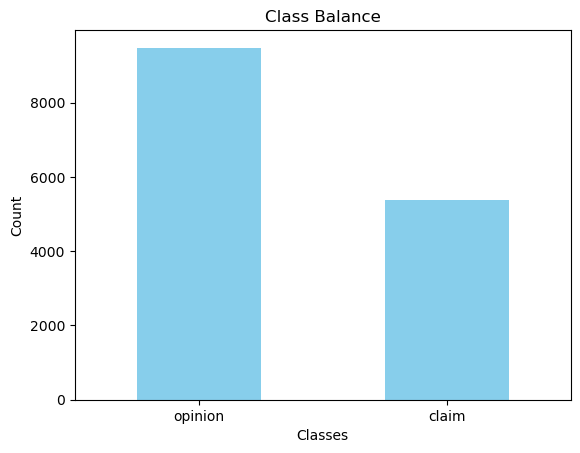

In [ ]:
# Check class balance
### YOUR CODE HERE ###

class_balance = df_cleaned['claim_status'].value_counts()
print("Class balance:")
print(class_balance)

# Optional: Visualize the class balance using a bar chart

class_balance.plot(kind='bar', color='skyblue')
plt.title('Class Balance')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [ ]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
### YOUR CODE HERE ###
df_cleaned = df_cleaned.copy()
df_cleaned.loc[:, 'text_length'] = df_cleaned['video_transcription_text'].str.len()


Calculate the average text_length for claims and opinions.

In [ ]:
# Calculate the average text_length for claims and opinions
### YOUR CODE HERE ###
average_text_length = df_cleaned.groupby('claim_status')['text_length'].mean()
print("Average text length for claims and opinions:")
print(average_text_length)

Average text length for claims and opinions:
claim_status
claim      95.654884
opinion    82.722562
Name: text_length, dtype: float64


Visualize the distribution of `text_length` for claims and opinions.

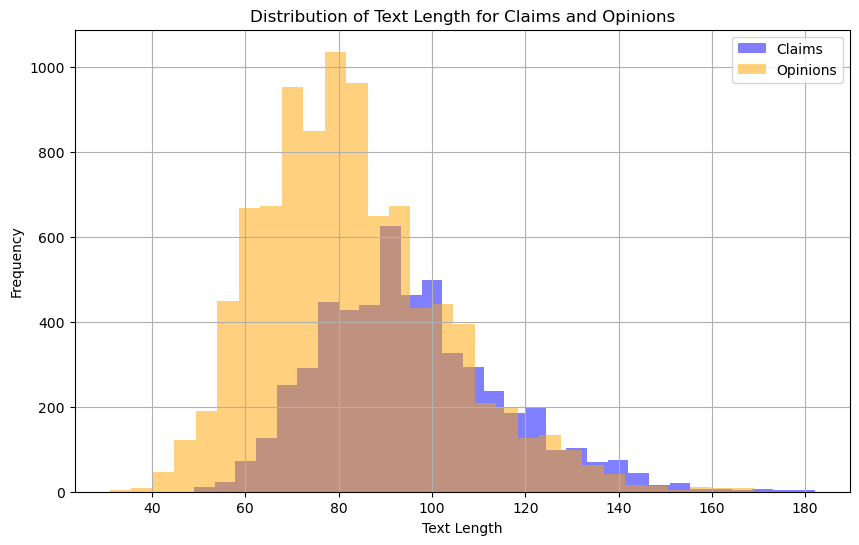

In [ ]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
### YOUR CODE HERE ###
plt.figure(figsize=(10, 6))
df_cleaned[df_cleaned['claim_status'] == 'claim']['text_length'].hist(alpha=0.5, label='Claims', bins=30, color='blue')
df_cleaned[df_cleaned['claim_status'] == 'opinion']['text_length'].hist(alpha=0.5, label='Opinions', bins=30, color='orange')
plt.title('Distribution of Text Length for Claims and Opinions')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Feature selection and transformation**

Encode target and catgorical variables.

In [ ]:
# Create a copy of the X data
### YOUR CODE HERE ###
df_final = df_cleaned.copy()
# Drop unnecessary columns
df_final = df_final.drop(['#', 'video_id', 'video_transcription_text'], axis=1)
# Encode target variable
df_final['claim_status'] = df_final['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
df_final = pd.get_dummies(df_final,
                   columns=['verified_status', 'author_ban_status'], drop_first=True)


### **Task 4: Split the data**

In [ ]:
df_final = df_final.astype(int)

In [ ]:
df_final.head()

Assign target variable.

In [ ]:
# Isolate target variable
### YOUR CODE HERE ###
y = df_final['claim_status']
y.head()

Isolate the features.

In [ ]:
# Isolate features
### YOUR CODE HERE ###
X = df_final.drop(columns=['claim_status'])  # Dropping the target variable

# Display first few rows of features dataframe
### YOUR CODE HERE ###
print(X.head())

#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [ ]:
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")


Length of X: 14851
Length of y: 14851


In [ ]:
# Split the data into training and testing sets
### YOUR CODE HERE ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [ ]:
# Split the training data into training and validation sets
### YOUR CODE HERE ###
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_final.head()

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [ ]:
# Get shape of each training, validation, and testing set
### YOUR CODE HERE ###
print(f"Training set shape: {X_train_final.shape}, {y_train_final.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [ ]:
# Instantiate the random forest classifier
### YOUR CODE HERE ###
rf_model = RandomForestClassifier(random_state=42)
# Create a dictionary of hyperparameters to tune
### YOUR CODE HERE ###
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Define a dictionary of scoring metrics to capture
### YOUR CODE HERE ###
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1'
}
# Instantiate the GridSearchCV object
### YOUR CODE HERE ###
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall',  # Focus on recall for the best model
                           cv=5,
                           return_train_score=True)

In [ ]:
# Examine best recall score
### YOUR CODE HERE ###
grid_search.fit(X_train_final, y_train_final)

# Examine best recall score
best_recall_score = grid_search.best_score_
print(f"Best Recall Score: {best_recall_score}")


Best Recall Score: 0.981780685842619


In [ ]:
  # Get all the results from the CV and put them in a df
### YOUR CODE HERE ###
cv_results = pd.DataFrame(grid_search.cv_results_)
  # Isolate the row of the df with the max(mean precision score)
### YOUR CODE HERE ###
best_row = cv_results[cv_results['mean_test_recall'] == cv_results['mean_test_recall'].max()]


In [ ]:
# Examine best parameters
### YOUR CODE HERE ###
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


### **Build an XGBoost model**

In [ ]:
# Instantiate the XGBoost classifier
### YOUR CODE HERE ###
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
# Create a dictionary of hyperparameters to tune
### YOUR CODE HERE ###
cv_params = {'max_depth': [4, 6],
               'min_child_weight': [3, 5],
               'learning_rate': [0.1, 0.2, 0.3],
               'n_estimators': [5,10,15],
               'subsample': [0.7],
               'colsample_bytree': [0.7]
               }
# Define a dictionary of scoring metrics to capture
### YOUR CODE HERE ###
scoring = {'accuracy', 'precision', 'recall', 'f1'}
# Instantiate the GridSearchCV object
### YOUR CODE HERE ###

xgb_cv = GridSearchCV(estimator=xgb,
                      param_grid=cv_params,
                      scoring=scoring,
                      cv=5,
                      refit='f1',  # Focus on F1 score for selecting the best model
                      return_train_score=True)

In [ ]:
%%time
# fit the GridSearch model to training data

### YOUR CODE HERE

xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

In [ ]:
# Apply your model to predict on your test data. Call this output "y_pred".

### YOUR CODE HERE ###

y_pred = xgb_cv.predict(X_test)

In [ ]:
  # Get all the results from the CV and put them in a df
### YOUR CODE HERE ###
cv_results = pd.DataFrame(xgb_cv.cv_results_)

  # Isolate the row of the df with the max(mean precision score)
### YOUR CODE HERE ###
best_precision_row = cv_results.loc[cv_results['mean_test_precision'].idxmax()]

# Print the row with the best precision
print("Best precision parameters:")
print(best_precision_row)

# Print the best parameters for F1 score
best_params_f1 = xgb_cv.best_params_
print(f"Best parameters for F1 score: {best_params_f1}")

# To examine all results and sort by a specific metric like precision:
sorted_results_by_precision = cv_results.sort_values(by='mean_test_precision', ascending=False)
print("Sorted results by precision:")
print(sorted_results_by_precision.head())


### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [ ]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
### YOUR CODE HERE ###
rf_best_model = grid_search.best_estimator_  # Assuming 'grid_search' contains the RF best model
rf_predictions = rf_best_model.predict(X_test)

Display the predictions on the encoded testing set.

In [ ]:
# Display the predictions on the encoded testing set
### YOUR CODE HERE ###
print("Random Forest Predictions:", rf_predictions)


Display the true labels of the testing set.

In [ ]:
# Display the true labels of the testing set
### YOUR CODE HERE ###
print("True Labels:", y_test)


Create a confusion matrix to visualize the results of the classification model.

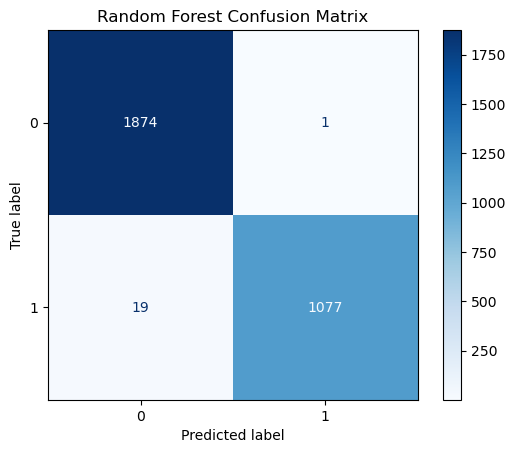

In [ ]:
# Create a confusion matrix to visualize the results of the classification model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Compute values for confusion matrix
### YOUR CODE HERE ###
rf_cm = confusion_matrix(y_test, rf_predictions)

# Create display of confusion matrix
### YOUR CODE HERE ###

rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)

# Plot confusion matrix
### YOUR CODE HERE ###

rf_disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')

# Display plot
### YOUR CODE HERE ###
plt.show()

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [ ]:
# Create a classification report
# Create classification report for random forest model
### YOUR CODE HERE ###
rf_report = classification_report(y_test, rf_predictions)
print("Random Forest Classification Report:")
print(rf_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1875
           1       1.00      0.98      0.99      1096

    accuracy                           0.99      2971
   macro avg       0.99      0.99      0.99      2971
weighted avg       0.99      0.99      0.99      2971



#### **XGBoost**

In [ ]:
#Evaluate XGBoost model
### YOUR CODE HERE ###
xgb_best_model = xgb_cv.best_estimator_  
xgb_predictions = xgb_best_model.predict(X_test)


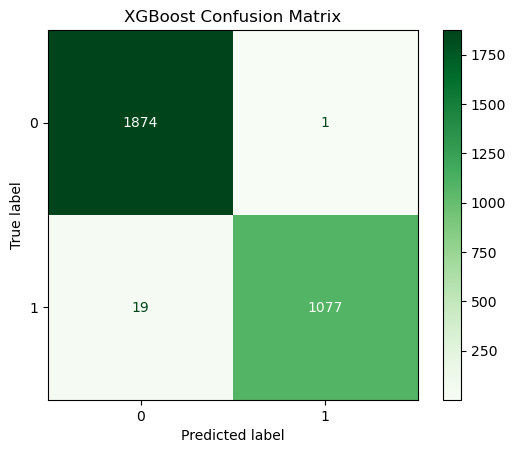

In [ ]:
# Compute values for confusion matrix
### YOUR CODE HERE ###
xgb_cm = confusion_matrix(y_test, xgb_predictions)

# Create display of confusion matrix
### YOUR CODE HERE ###
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm)

# Plot confusion matrix
### YOUR CODE HERE ###
xgb_disp.plot(cmap='Greens')
plt.title('XGBoost Confusion Matrix')

# Display plot
### YOUR CODE HERE ###
plt.show()

In [ ]:
# Create a classification report
### YOUR CODE HERE ###
xgb_report = classification_report(y_test, xgb_predictions)
print("XGBoost Classification Report:")
print(xgb_report)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1875
           1       1.00      0.98      0.99      1096

    accuracy                           0.99      2971
   macro avg       0.99      0.99      0.99      2971
weighted avg       0.99      0.99      0.99      2971



### **Use champion model to predict on test data**

In [ ]:
### YOUR CODE HERE ###
champion_model = xgb_best_model
champion_predictions = champion_model.predict(X_test)


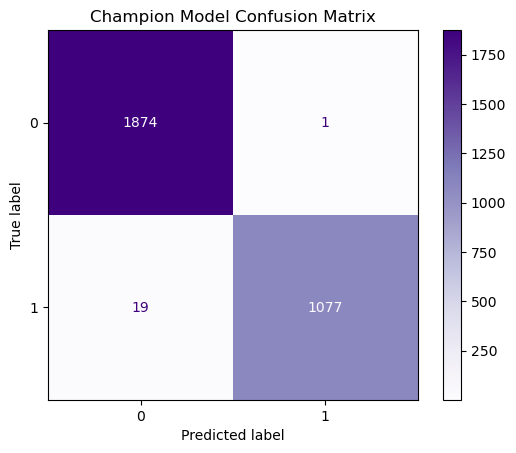

In [ ]:
# Compute values for confusion matrix
### YOUR CODE HERE ###
champion_cm = confusion_matrix(y_test, champion_predictions)

# Create display of confusion matrix
### YOUR CODE HERE ###
champion_disp = ConfusionMatrixDisplay(confusion_matrix=champion_cm)

# Plot confusion matrix
### YOUR CODE HERE ###
champion_disp.plot(cmap='Purples')
plt.title('Champion Model Confusion Matrix')

# Display plot
### YOUR CODE HERE ###
plt.show()

#### **Feature importances of champion model**


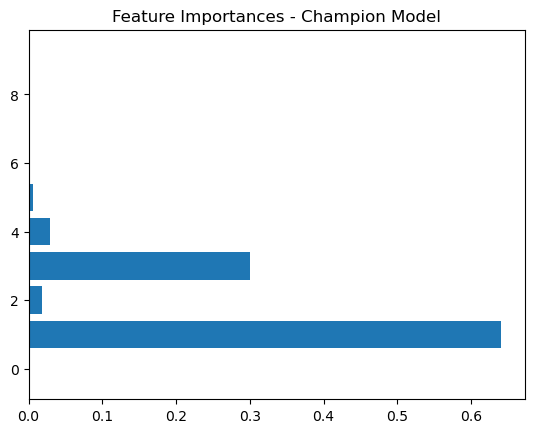

In [ ]:
### YOUR CODE HERE ###
importances = champion_model.feature_importances_
plt.barh(range(len(importances)), importances)
plt.title('Feature Importances - Champion Model')
plt.show()

Based on the performance metrics (precision, recall, F1-score, accuracy) and the comparison of the confusion matrices, XGBoost performed slightly better in terms of recall and precision. This suggests it can effectively balance the trade-off between false positives and false negatives. If the focus of the task is minimizing false negatives (e.g., if the cost of missing a positive case is high), I would recommend using XGBoost as the champion model.

However, if the application prioritizes other metrics such as training speed, simplicity, or interpretability, Random Forest may be preferable due to its generally easier interpretability and faster training times. XGBoost can sometimes be computationally heavier but offers more precision in fine-tuning.

Both models—Random Forest and XGBoost—are ensemble methods that combine predictions from multiple decision trees. Here's how they made predictions:

Random Forest: It works by constructing multiple decision trees and averaging their predictions (for classification, it takes the majority vote). Each tree is built on a random subset of the data, and features are randomly selected at each split, leading to reduced overfitting and improved generalization.

XGBoost: It uses gradient boosting, which sequentially builds trees where each tree tries to correct the errors of the previous ones. It optimizes a differentiable loss function, and during training, it adjusts model parameters to minimize the loss. This method is typically more accurate than Random Forest due to the iterative improvement process.

**Congratulations!** Project completed!!!!
<br> 
Thanks for visiting!